**This notebook demonstrates Sentinel 2 image fusion (MS-MS fusion) using SURE and BP:**
- Data: Real S2 data downloaded from  https://scihub.copernicus.eu/dhus/#/home
    - 6 bands of 20 m and 2 bands of 60 m are fused with 4 bands 10 m to obtain all bands of 10 m
- Loss function $$\mathcal{L}_{sure}=\|\mathbf{P}(\mathbf{y}-\mathbf{H}f_\theta(\mathbf{y})\|^2)+2\text{tr}\big[(\Omega_P)\mathbf{PH}\frac{\partial f_\theta(\mathbf{z})}{\partial\mathbf{u}}\big],$$
where $\mathbf{P}$ is a linear operator mapping LR image to its HR space, $\mathbf{z}$ is the network input (concatenating $\mathbf{u}=\mathbf{H^\dagger y}$ and $\mathbf{G}$) and $f_\theta(\cdot)$ is the network output.

In [1]:
# =============================================================================
# import lib
# =============================================================================
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.optim
import scipy.io as sio
from models.s2_models import *
from utils.s2_utils import *
from utils.common_utils import *
from skimage.restoration import estimate_sigma
torch.cuda.get_device_name()

'NVIDIA TITAN X (Pascal)'

In [2]:
# =============================================================================
# load data
# =============================================================================
d = np.array([6, 1, 1, 1, 2, 2, 2, 1, 2, 6, 2, 2])
mtf = np.array([.32, .26, .28, .24, .38, .34, .34, .26, .33, .26, .22, .23])
path_to_data = 'data/S2/vietnam.mat'
x10 = sio.loadmat(path_to_data)['y10'].astype(np.float32)
x20 = sio.loadmat(path_to_data)['y20'].astype(np.float32)
x60 = sio.loadmat(path_to_data)['y60'].astype(np.float32)
scale=np.max((np.max(x20),np.max(x10),np.max(x60)))
x10=x10/scale
x20=x20/scale
x60=x60/scale
Y60 = hwc2chw(torch.from_numpy(x60)).to(device)
Y20 = hwc2chw(torch.from_numpy(x20)).to(device)
Y10 = hwc2chw(torch.from_numpy(x10)).to(device)
cond=1e-4
psf20 = get_s2psf(band='band20')
psf60 = get_s2psf(band='band60')
psf10 = get_s2psf(band='band10')
sigma10 = estimate_sigma(x10,multichannel=True)
sigma20 = estimate_sigma(x20,multichannel=True)
sigma60 = estimate_sigma(x60,multichannel=True)

In [3]:
sigma20=torch.Tensor(sigma20).to(device)
sigma10=torch.Tensor(sigma10).to(device)
sigma60=torch.Tensor(sigma60).to(device)
y20ml = back_projx(Y20,psf20,2,cond)
y60ml = back_projx(Y60,psf60,6,cond)
sigmas=[sigma10,sigma20,sigma60]

60 m bands shape:  torch.Size([2, 70, 70])
20 m bands shape:  torch.Size([6, 210, 210])
10 m bands shape:  torch.Size([4, 420, 420])


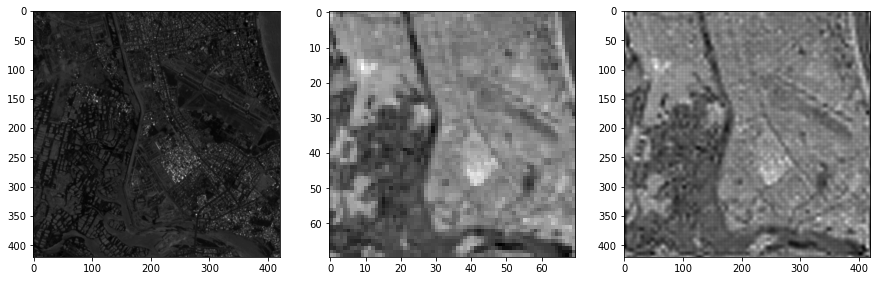

In [4]:
# =============================================================================
# show images
# =============================================================================
print('60 m bands shape: ', Y60.shape)
print('20 m bands shape: ', Y20.shape)
print('10 m bands shape: ', Y10.shape)
thresholdRGB=1
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15,15))
ax1.imshow(Y10[1,:,:].cpu(),cmap='gray')
ax2.imshow(Y60[1,:,:].cpu(),cmap='gray')
ax3.imshow(y60ml[1,:,:].cpu(),cmap='gray')
plt.show()

In [5]:
net_input = torch.cat((Y10,y20ml,y60ml),dim=0)[None,:]
# inputs=torch.randn(net_input.shape).to(device)
y=[Y10,Y20,Y60]

In [6]:
def s2_sure_loss(z,y,net,sigmas,psfs,cond,loss_type="sure"):
    '''BP, and BP-SURE losses
    z: input (1,c,m,n); y:observation (target); net: network; sigmas: sigmas for 10, 20 and 60 bands
    psfs: psfs for 10, 20, and 60 m bands; cond=1e-3; loss_type: "sure" or "bp"'''
    psf20=psfs[0]
    psf60=psfs[1]
    sigma10=sigmas[0]**2
    sigma20=sigmas[1]**2
    sigma60=sigmas[2]**2
    y10=y[0]
    y20=y[1]
    y60=y[2]
    xhat = net(z)
    hxhat20 = Ax(xhat.squeeze()[4:10,:,:],psf20,2) - y20
    hxhat60 = Ax(xhat.squeeze()[10:,:,:], psf60, 6) - y60
    pxhat10 = xhat.squeeze()[:4,:,:] - y10
    pxhat20 = back_projx(hxhat20,psf20,2,cond)
    pxhat60 = back_projx(hxhat60, psf60, 6, cond)
    
    loss_bp = torch.sum(pxhat10**2)+torch.sum(pxhat20**2)+torch.sum(pxhat60**2)
    # Compute divergence term by Monte-Carlo SURE
    ep = 1e-5
    b=torch.randn(z.shape).to(device)
    oute = (net(z+ep*b)-xhat)/ep
    houte20=Ax(oute.squeeze()[4:10,:,:],psf20,2)
    houte60=Ax(oute.squeeze()[10:,:,:],psf60,6)
    tmp20=invAAtx(houte20,psf20,2,cond)*sigma20.reshape(6,1,1)
    tmp60=invAAtx(houte60,psf60,6,cond)*sigma60.reshape(2,1,1)
    outep20 = back_projx(tmp20,psf20,2,cond)
    outep60 = back_projx(tmp60, psf60, 6, cond)
    outep10 = oute.squeeze()[:4,:,:]*sigma10.reshape(4,1,1)

    div = torch.sum(b.squeeze()[:4,:,:]*outep10) + torch.sum(b.squeeze()[4:10,:,:]*outep20) +torch.sum(b.squeeze()[10:,:,:]*outep60)
    if loss_type == "bp":
        return loss_bp,xhat
    elif loss_type=="sure":
        return loss_bp+2*div,xhat
    else:
        print("none of loss used")


In [7]:
# =============================================================================
# Set parameters and net
# =============================================================================
show_every = 200
num_iter = 1001
LR = 0.01
thresholdRGB=1.
showband10=[0,1,2]
showband20=[9,7,4]
showband60=[10,11,10]
# net=s2_net().type(dtype)
net=s2_attention_net().type(dtype)
psfs=[psf20,psf60]

Starting optimization with ADAM with sure loss
Iteration 00000 


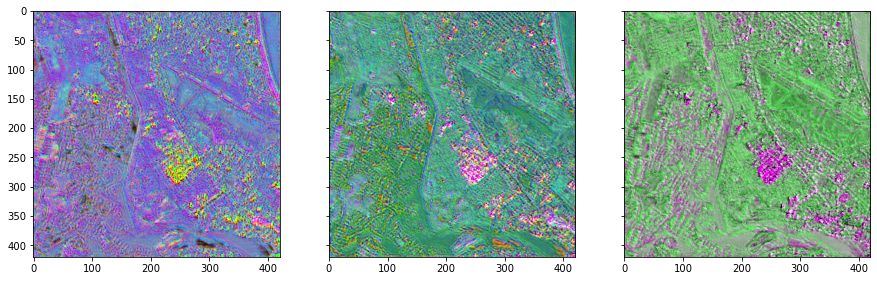

Iteration 00200 


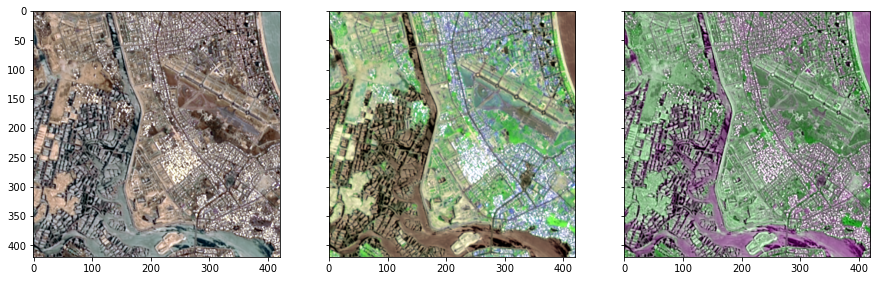

Iteration 00400 


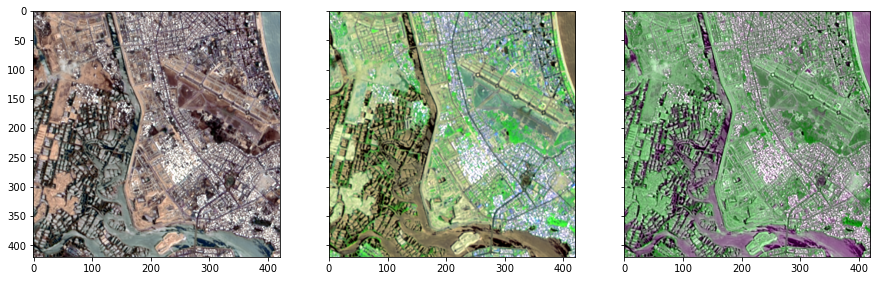

Iteration 00600 


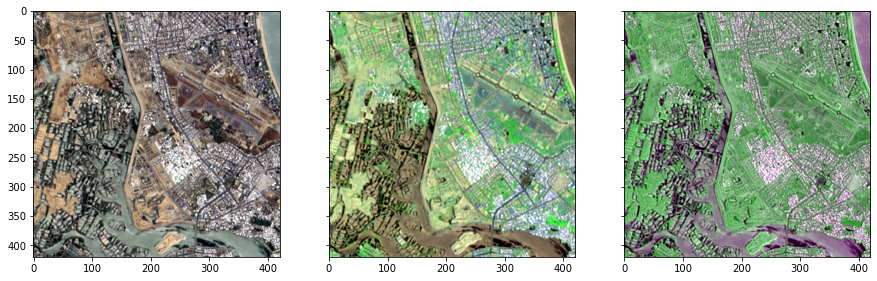

Iteration 00800 


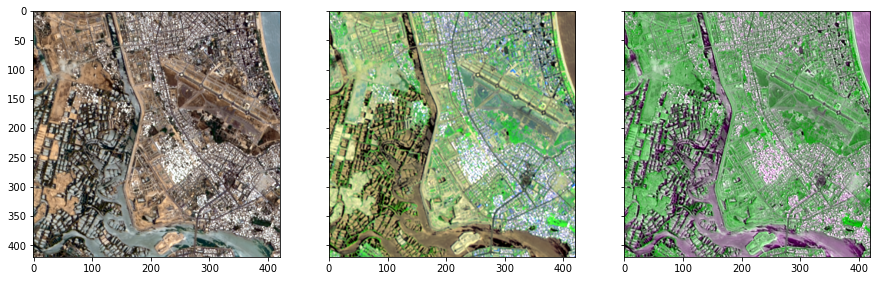

Iteration 01000 


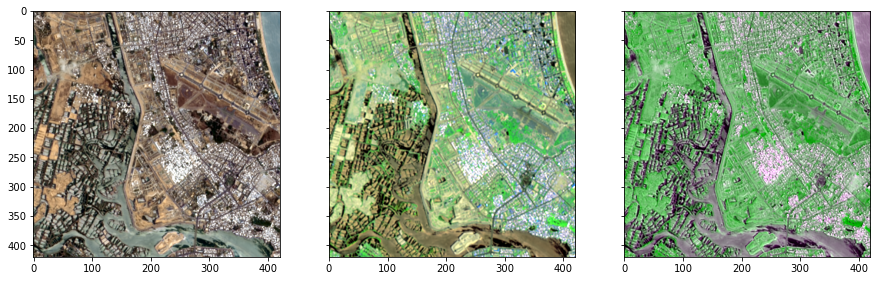

In [8]:
# =============================================================================
# Optimization
# =============================================================================
out_avg=None
exp_weight=0.99
loss_type="sure"
p = net.parameters()
print('Starting optimization with ADAM with '+loss_type+" loss")
optimizer = torch.optim.Adam(p, lr=LR,eps=1e-3,amsgrad=True)
for it in range(num_iter):
#     net_input = inputs+0.03*torch.randn(inputs.shape).to(device)
    optimizer.zero_grad()
    loss,xhat = s2_sure_loss(net_input,y,net,sigmas,psfs,cond,loss_type=loss_type)
    out_np = chw2hwc(xhat.detach().cpu().squeeze()).numpy()

#     if out_avg is None:
#             out_avg = out_np
#     else:
#         out_avg = out_avg * exp_weight + out_np * (1 - exp_weight)
#     if it==1500:
#         sio.savemat("vietnam_out"+loss_type+".mat",mdict={"img_"+loss_type:out_avg})

    loss.backward()
    optimizer.step()
    if it % show_every == 0:
        print('Iteration %05d ' % (it))
        out=out_np*scale
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
        ax1.imshow(sentinel2RGB(out[:,:,showband10],thresholdRGB))
        ax2.imshow(sentinel2RGB(out[:,:,showband20],thresholdRGB))
        ax3.imshow(sentinel2RGB(out[:,:,showband60],thresholdRGB))
        plt.show()